In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import xarray as xr

import pycomlink as pycml

# Load example data and look at one CML

In [4]:
cml_list = pycml.io.examples.get_75_cmls()

100%|██████████| 75/75 [00:01<00:00, 74.67it/s]


In [5]:
cml = cml_list[0]
cml

<xarray.Dataset>
Dimensions:           (channel_id: 2, time: 2750)
Coordinates:
  * time              (time) datetime64[ns] 2017-06-28T00:00:10.241754112 ......
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    cml_id            |S17 b'MY1394_2_MY2336_4'
    site_a_latitude   float64 50.26
    site_b_latitude   float64 50.38
    site_a_longitude  float64 50.91
    site_b_longitude  float64 50.81
    frequency         (channel_id) float64 18.2 19.2
    polarization      |S1 b'V'
    length            float64 13.48
Data variables:
    tsl               (channel_id, time) float64 14.0 14.0 14.0 ... 14.0 13.0
    rsl               (channel_id, time) float64 -47.0 -47.0 ... -47.0 -47.0

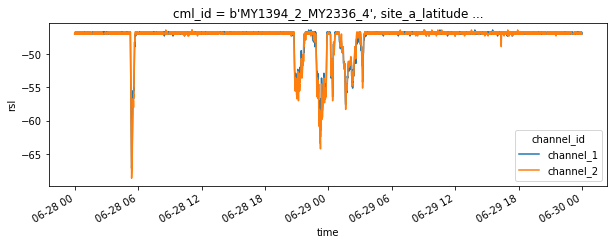

In [6]:
cml.rsl.plot.line(x='time', figsize=(10,3));

# Set default values to NaN and calculate TRSL
TRSL is the transmitted signal level minus the received signal level and represents the total path loss along the CML

In [7]:
for cml in cml_list:
    cml['tsl'] = cml.tsl.where(cml.tsl != 255.0)
    cml['rsl'] = cml.rsl.where(cml.rsl != -99.9)
    cml['trsl'] = cml.tsl - cml.rsl

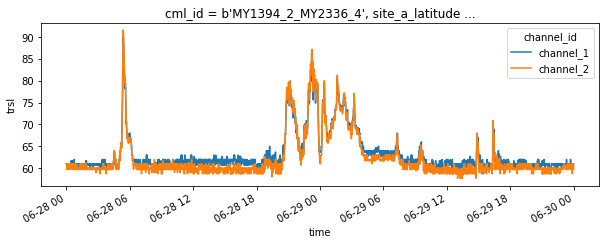

In [8]:
cml = cml_list[0]
cml.trsl.plot.line(x='time', figsize=(10,3));

# Do simple wet-dry classification using a rolling standard deviation 

In [9]:
threshold = 0.8

roll_std_dev = cml.trsl.rolling(time=60, center=True).std()
cml['wet'] = cml.trsl.rolling(time=60, center=True).std() > threshold

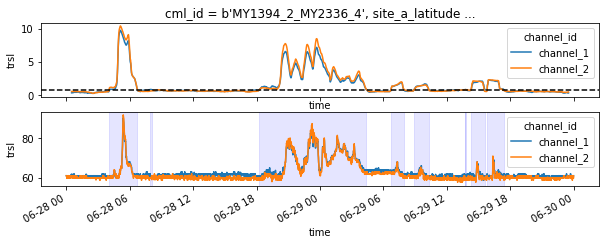

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(10,3), sharex=True)

roll_std_dev.plot.line(x='time', ax=axs[0])
axs[0].axhline(threshold, color='k', linestyle='--')

cml.trsl.plot.line(x='time', ax=axs[1]);

# Get start and end of dry event
wet_start = np.roll(cml.wet, -1) & ~cml.wet
wet_end = np.roll(cml.wet, 1) & ~cml.wet

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start.isel(channel_id=0).values.nonzero()[0],
    wet_end.isel(channel_id=0).values.nonzero()[0],
):
    axs[1].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1)

axs[1].set_title('');

# Determine baseline

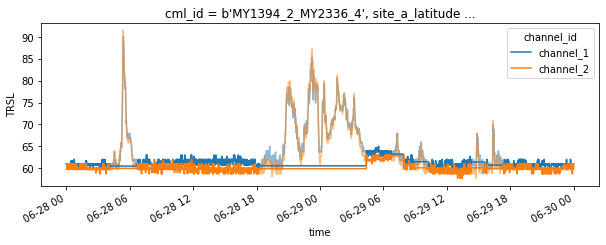

In [11]:
cml['baseline'] = pycml.processing.baseline.baseline_constant(trsl=cml.trsl, wet=cml.wet, n_average_last_dry=5)

fig, ax = plt.subplots(figsize=(10,3))

cml.trsl.plot.line(x='time', alpha=0.5)
plt.gca().set_prop_cycle(None)
cml.baseline.plot.line(x='time');
plt.gca().set_prop_cycle(None)
plt.ylabel('TRSL');

# Perform wet antenna estimation and compare to uncorrected baseline 

In [12]:
cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl, 
    baseline=cml.baseline, 
    wet=cml.wet, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)

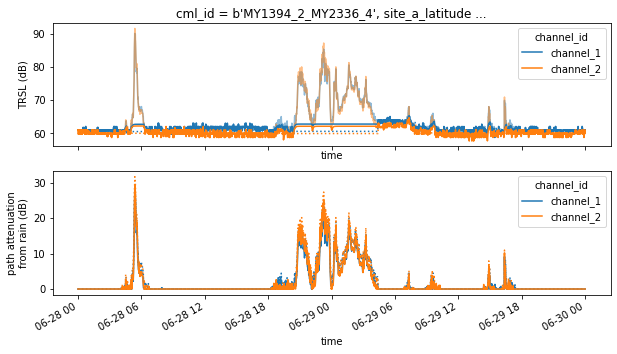

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(10,5), sharex=True)

plt.sca(axs[0])
cml.trsl.plot.line(x='time', alpha=0.5)
plt.gca().set_prop_cycle(None)
cml.baseline.plot.line(x='time', linestyle=':');
plt.gca().set_prop_cycle(None)
(cml.baseline + cml.waa).plot.line(x='time');
plt.ylabel('TRSL (dB)')

plt.sca(axs[1])
cml['A'] = cml.trsl - cml.baseline - cml.waa
cml['A'] = cml.A.where(cml.A > 0, 0)
cml['A_no_waa_correct'] = cml.trsl - cml.baseline
cml['A_no_waa_correct'] = cml.A_no_waa_correct.where(cml.A_no_waa_correct > 0, 0)
cml.A_no_waa_correct.plot.line(x='time', linestyle=':');
plt.gca().set_prop_cycle(None)
cml.A.plot.line(x='time');
plt.ylabel('path attenuation\nfrom rain (dB)');
axs[1].set_title('');

# Calculate rain rate

In [14]:
cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(A=cml.A, L_km=cml.length, f_GHz=cml.frequency)

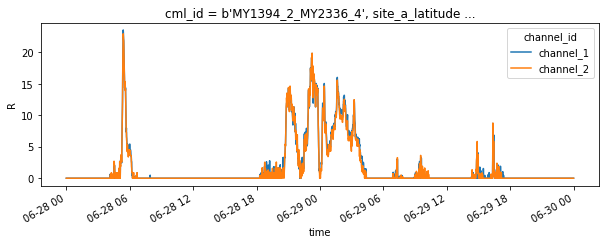

In [15]:
fig, ax = plt.subplots(figsize=(10,3))
cml.R.plot.line(x='time');

# Now do the whole processing for all CMLs 

In [16]:
for cml in tqdm.tqdm(cml_list):
    cml['wet'] = cml.trsl.rolling(time=60, center=True).std() > 0.8
    cml['baseline'] = pycml.processing.baseline.baseline_constant(
        trsl=cml.trsl, 
        wet=cml.wet, 
        n_average_last_dry=5,
    )
    cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
        rsl=cml.trsl, 
        baseline=cml.baseline, 
        wet=cml.wet, 
        waa_max=2.2, 
        delta_t=1, 
        tau=15,
    )
    cml['A'] = cml.trsl - cml.baseline - cml.waa
    cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(A=cml.A, L_km=cml.length, f_GHz=cml.frequency)


100%|██████████| 75/75 [00:03<00:00, 23.62it/s]


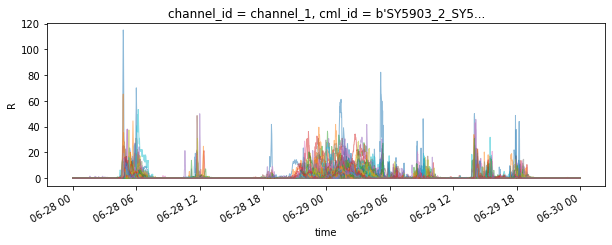

In [17]:
fig, ax = plt.subplots(figsize=(10,3))

for cml in cml_list:
    cml.R.isel(channel_id=0).plot.line(x='time', ax=ax, alpha=0.5, linewidth=1)

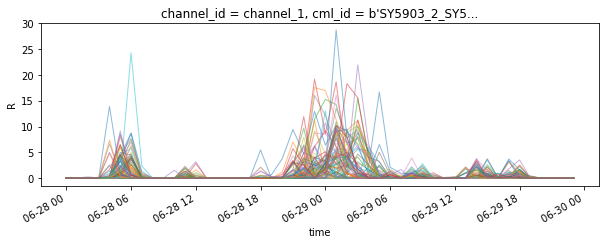

In [18]:
fig, ax = plt.subplots(figsize=(10,3))

for cml in cml_list:
    cml.R.isel(channel_id=0).resample(time='H').mean().plot.line(x='time', ax=ax, alpha=0.5, linewidth=1)

# Create rainfall field via IDW interpolation 

First, we resample the CML rain rate data from 1 minute resolution with raw time stamps (which are, in our case, not located at the full minutes) to 1-hour averages. We then combine all CMLs into one `xarray.Dataset` because it is more convenient to use in this case.

In [19]:
cmls_R_1h = xr.concat(
    objs=[cml.R.resample(time='1h', label='right').mean() for cml in cml_list],
    dim='cml_id',
)

In [20]:
cmls_R_1h

<xarray.DataArray 'R' (cml_id: 75, channel_id: 2, time: 48)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * time              (time) datetime64[ns] 2017-06-28T01:00:00 ... 2017-06-30
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
  * cml_id            (cml_id) object b'MY1394_2_MY2336_4' ... b'SY5903_2_SY5...
    site_a_latitude   (cml_id) float64 50.26 50.44 50.58 ... 50.3 50.32 50.31
    site_b_latitude   (cml_id) float64 50.38 50.38 50.61 ... 50.28 50.46 50.32
    site_a_longitude  (cml_id) float64 50.91 50.85 51.09 ... 50.25 50.38 50.4
    site_b_longitude  (cml_id) float64 50.81 50.81 51.15 ... 50.3 50.41 50.38
    frequency         (cml_id, channel_id) float64 18.2 19.2 ... 38.68 37.42
    polarization      (cml_id) |S1 b'V' b'V' b'H' b'V' ... b'H' b'H' b'V' b'V'
    length            (cml_id) float64 13.48 5.691 7.65 ... 5.942 10.44 2.673

Add coordinates of center location of CMLs

In [21]:
cmls_R_1h['lat_center'] = (cmls_R_1h.site_a_latitude + cmls_R_1h.site_b_latitude)/2
cmls_R_1h['lon_center'] = (cmls_R_1h.site_a_longitude + cmls_R_1h.site_b_longitude)/2

Set up the IDW interpolator

In [22]:
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=15, 
    p=3, 
    exclude_nan=True, 
    max_distance=0.3,
)

Derive and plot rainfall maps of rainfall sum over period

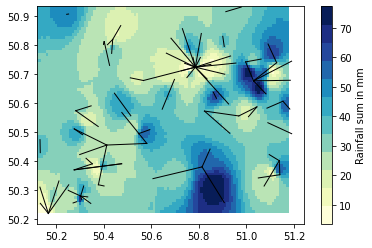

In [23]:
def plot_cml_lines(ds_cmls, ax):
    ax.plot(
        [cmls_R_1h.site_a_longitude, cmls_R_1h.site_b_longitude],
        [cmls_R_1h.site_a_latitude, cmls_R_1h.site_b_latitude],
        'k',
        linewidth=1,
    )

R_grid = idw_interpolator(
    x=cmls_R_1h.lon_center, 
    y=cmls_R_1h.lat_center, 
    z=cmls_R_1h.isel(channel_id=0).sum(dim='time'), 
    resolution=0.01,
)

fig, ax = plt.subplots()
pc = plt.pcolormesh(idw_interpolator.xgrid, idw_interpolator.ygrid, R_grid, shading='nearest', cmap=plt.get_cmap('YlGnBu', 12))
plot_cml_lines(cmls_R_1h, ax=ax)
fig.colorbar(pc, label='Rainfall sum in mm');

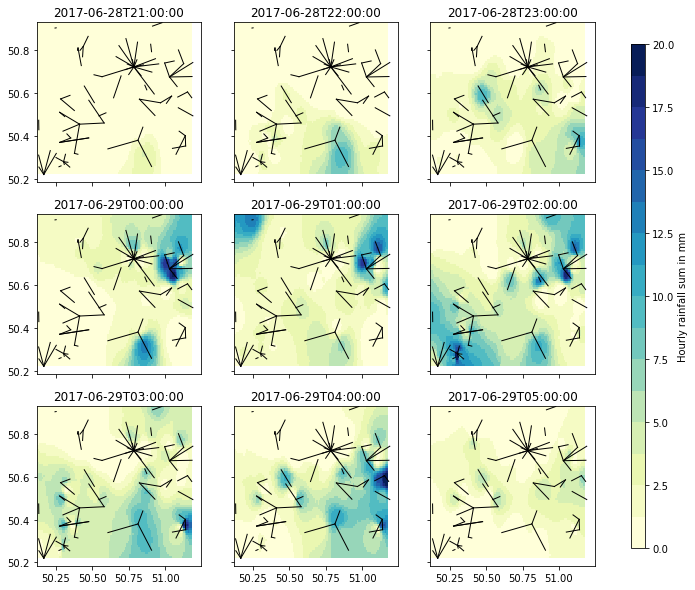

In [24]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))

for i, axi in enumerate(ax.flat):
    R_grid = idw_interpolator(
        x=cmls_R_1h.lon_center, 
        y=cmls_R_1h.lat_center, 
        z=cmls_R_1h.isel(channel_id=0).isel(time=i + 20), 
        resolution=0.01,
    )
    pc = axi.pcolormesh(
        idw_interpolator.xgrid, 
        idw_interpolator.ygrid, 
        R_grid, 
        shading='nearest', 
        cmap=plt.get_cmap('YlGnBu', 16),
        vmin=0,
        vmax=20,
    )
    axi.set_title(str(cmls_R_1h.time.values[i + 20])[:19])
    
    plot_cml_lines(cmls_R_1h, ax=axi)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, label='Hourly rainfall sum in mm');